"""
================================================================================
DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION
Convolutional Neural Networks: Custom Implementation vs Transfer Learning
================================================================================

"""
================================================================================
STUDENT INFORMATION (REQUIRED - DO NOT DELETE)
================================================================================

# **Group Details**

**Group No:** 43

---

### **Group Members**

| ID | Name | Email | Contribution |
|------|------|--------|--------------|
|**2024ac05402**| **KUNCHA AMRUTHAVALLI** | 2024ac05402@wilp.bits-pilani.ac.in | 100% |
|**2024ac05636**| **SHAIKH SIMRAN ASLAM** | 2024AC05636@wilp.bits-pilani.ac.in | 100% |
|**2024ad05216**| **BOBWILLIS K** | 2024ad05216@wilp.bits-pilani.ac.in | 100% |
|**2024ac05829**| **SAJJALA ASHOK REDDY** | 2024AC05829@wilp.bits-pilani.ac.in | 100% |

---

Date: 15-02-2026


"""
================================================================================

In [45]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import os

# Deep learning frameworks (choose Keras or PyTorch)
# For image processing
from PIL import Image
import cv2


"""
================================================================================
PART 1: DATASET LOADING AND EXPLORATION (Informational)
================================================================================
Instructions:
1. Choose ONE dataset from the allowed list
2. Load and explore the data
3. Fill in ALL required metadata fields below
4. Provide justification for your primary metric choice

ALLOWED DATASETS:
- Cats vs Dogs (2 classes)
- Food-101 subset (10-20 classes)
- Plant Disease (3-5 classes)
- Medical Images (2-3 classes)
- Custom dataset (with IC approval, min 500 images per class)

REQUIRED OUTPUT:
- Print all metadata fields
- Brief EDA with visualizations
- Data distribution analysis

================================================================================
"""

In [46]:
!pip -q install tensorflow tensorflow-datasets scikit-learn

import os, time, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [47]:
# =========================
# 1.1 Dataset Selection
# =========================
# Chosen dataset (meets 500/class constraint)
dataset_name   = "cats_vs_dogs"
dataset_source = "tensorflow_datasets (TFDS)"
problem_type   = "classification"

image_shape = [224, 224, 3]
IMG_SIZE = (224, 224)

train_test_ratio = "90/10"

# Primary metric (binary + roughly balanced => hence accuracy is acceptable)
primary_metric = "accuracy"
metric_justification = (
    "Accuracy is appropriate here because the dataset is a balanced binary classification task, "
    "so overall correct classification rate is a meaningful primary measure."
)

# Load dataset
ds_all, ds_info = tfds.load(dataset_name, split="train", as_supervised=True, with_info=True)

n_samples = int(ds_info.splits["train"].num_examples)
n_classes = int(ds_info.features["label"].num_classes)

# Compute train/test sample counts for 90/10
train_samples = int(0.9 * n_samples)
test_samples  = n_samples - train_samples

print("Dataset loaded.")
print("Total samples:", n_samples)
print("Train samples:", train_samples)
print("Test samples:", test_samples)
print("Classes:", n_classes)


Dataset loaded.
Total samples: 23262
Train samples: 20935
Test samples: 2327
Classes: 2


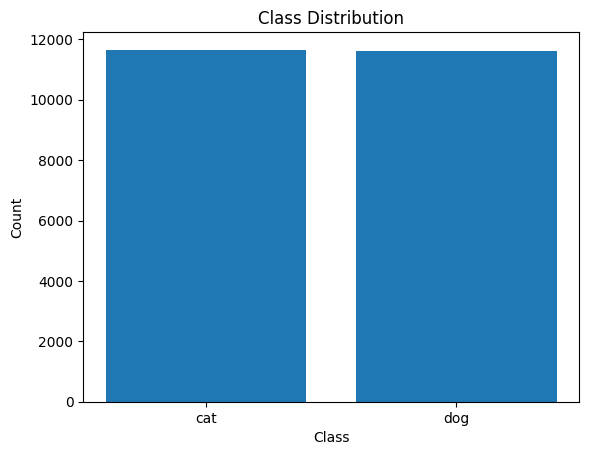

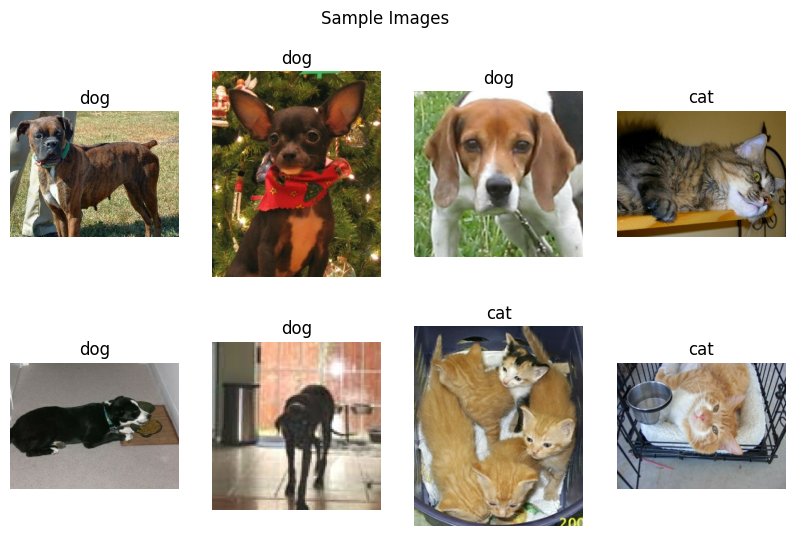

Pixel mean (RGB): [0.47899422 0.43724722 0.3810158 ]
Pixel std  (RGB): [0.25173727 0.2429612  0.24624343]


In [48]:
# Class names from TFDS (cats_vs_dogs: 0=cat, 1=dog)
class_names = ds_info.features["label"].names

# class distribution (single pass)
counts = np.zeros(n_classes, dtype=int)
for _, y in tfds.as_numpy(ds_all):
    counts[y] += 1

samples_per_class = f"min: {counts.min()}, max: {counts.max()}, avg: {counts.mean():.1f}"

# class distribution plot
plt.figure()
plt.bar(class_names, counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# sample images plot
plt.figure(figsize=(10, 6))
for i, (img, label) in enumerate(tfds.as_numpy(ds_all.take(8))):
    ax = plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(class_names[int(label)])
    plt.axis("off")
plt.suptitle("Sample Images")
plt.show()

# image stats (on a small sample for speed)
sample_pixels = []
for img, _ in tfds.as_numpy(ds_all.take(200)):
    sample_pixels.append(img.astype(np.float32) / 255.0)
sample_pixels = np.concatenate([x.reshape(-1, 3) for x in sample_pixels], axis=0)
print("Pixel mean (RGB):", sample_pixels.mean(axis=0))
print("Pixel std  (RGB):", sample_pixels.std(axis=0))


In [49]:
print("\n" + "="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")
print("="*70)


DATASET INFORMATION
Dataset: cats_vs_dogs
Source: tensorflow_datasets (TFDS)
Total Samples: 23262
Number of Classes: 2
Samples per Class: min: 11604, max: 11658, avg: 11631.0
Image Shape: [224, 224, 3]
Primary Metric: accuracy
Metric Justification: Accuracy is appropriate here because the dataset is a balanced binary classification task, so overall correct classification rate is a meaningful primary measure.


In [50]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
SEED = 42

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE) # resize
    image = tf.cast(image, tf.float32) / 255.0 # normalization
    return image, label

# Shuffling once, and then to split deterministically
ds_all_shuffled = ds_all.shuffle(buffer_size=5000, seed=SEED, reshuffle_each_iteration=False)

ds_train = ds_all_shuffled.take(train_samples).map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test  = ds_all_shuffled.skip(train_samples).map(preprocess, num_parallel_calls=AUTOTUNE)

ds_train = ds_train.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_test  = ds_test.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Train/Test Split:", train_test_ratio)
print("Training Samples:", train_samples)
print("Test Samples:", test_samples)


Train/Test Split: 90/10
Training Samples: 20935
Test Samples: 2327


"""
================================================================================
PART 2: CUSTOM CNN IMPLEMENTATION (5 MARKS)
================================================================================
"""

2.1 Custom CNN Architecture Design

In [51]:
def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture

    Args:
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes

    Returns:
        model: compiled CNN model
    """
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="custom_cnn_gap")
    return model


In [52]:
# Create model instance
custom_cnn = build_custom_cnn(tuple(image_shape), n_classes)
custom_cnn.summary()

# Compile model (Keras)
custom_lr = 1e-3
custom_epochs = 5

custom_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=custom_lr),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

custom_cnn_conv_layers = sum(isinstance(l, layers.Conv2D) for l in custom_cnn.layers)
custom_cnn_pooling_layers = sum(isinstance(l, (layers.MaxPooling2D, layers.AveragePooling2D)) for l in custom_cnn.layers)
custom_cnn_total_parameters = int(custom_cnn.count_params())

print("Custom CNN Conv layers:", custom_cnn_conv_layers)
print("Custom CNN Pooling layers:", custom_cnn_pooling_layers)
print("Custom CNN Total parameters:", custom_cnn_total_parameters)

custom_loss_function_name = "sparse_categorical_crossentropy"
custom_optimizer_name = "Adam"
custom_batch_size = int(BATCH_SIZE)


Model: "custom_cnn_gap"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,506 (365.26 KB)

 Trainable params: 93,506 (365.26 KB)

 Non-trainable params: 0 (0.00 B)

Custom CNN Conv layers: 3
Custom CNN Pooling layers: 2
Custom CNN Total parameters: 93506


2.2 Train Custom CNN

In [53]:
print("\n" + "="*70)
print("CUSTOM CNN TRAINING")
print("="*70)

custom_cnn_start_time = time.time()

history = custom_cnn.fit(
    ds_train,
    validation_data=ds_test,
    epochs=custom_epochs,
    verbose=1
)

custom_cnn_training_time = time.time() - custom_cnn_start_time

# Track initial and final loss
custom_cnn_initial_loss = float(history.history["loss"][0])
custom_cnn_final_loss   = float(history.history["loss"][-1])

print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")
print("="*70)


CUSTOM CNN TRAINING
Epoch 1/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 0.5636 - loss: 0.6725 - val_accuracy: 0.6175 - val_loss: 0.6270
Epoch 2/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.6243 - loss: 0.6342 - val_accuracy: 0.6730 - val_loss: 0.5899
Epoch 3/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 44s 64ms/step - accuracy: 0.6740 - loss: 0.6003 - val_accuracy: 0.7151 - val_loss: 0.5518
Epoch 4/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.6962 - loss: 0.5767 - val_accuracy: 0.7267 - val_loss: 0.5363
Epoch 5/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.7103 - loss: 0.5650 - val_accuracy: 0.7297 - val_loss: 0.5297
Training completed in 227.41 seconds
Initial Loss: 0.6570
Final Loss: 0.5583


2.3 Evaluate Custom CNN

In [54]:
# Ground-truth labels from ds_test
y_test = []
for _, labels in ds_test:
    y_test.extend(labels.numpy().tolist())
y_test = np.array(y_test)

# Predict
y_prob = custom_cnn.predict(ds_test, verbose=0)
y_pred_custom = np.argmax(y_prob, axis=1)

# REQUIRED: Calculate all 4 metrics (macro averaging)
custom_cnn_accuracy  = float(accuracy_score(y_test, y_pred_custom))
custom_cnn_precision = float(precision_score(y_test, y_pred_custom, average='macro', zero_division=0))
custom_cnn_recall    = float(recall_score(y_test, y_pred_custom, average='macro', zero_division=0))
custom_cnn_f1        = float(f1_score(y_test, y_pred_custom, average='macro', zero_division=0))

print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")



Custom CNN Performance:
Accuracy:  0.7297
Precision: 0.7435
Recall:    0.7312
F1-Score:  0.7266


2.4 Visualize Custom CNN Results

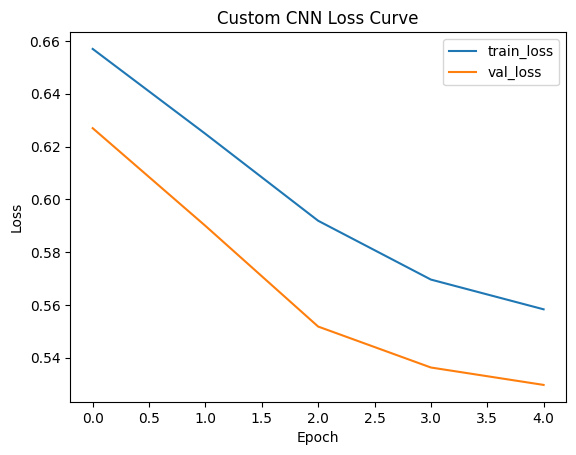

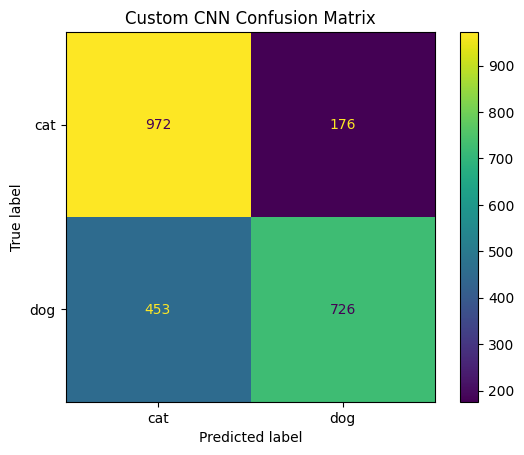

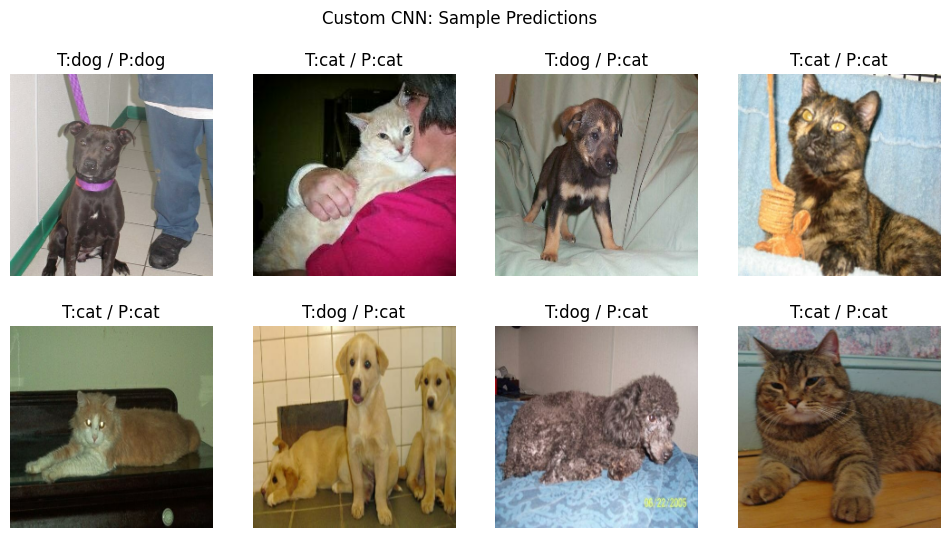

In [55]:
# Plot training loss curve
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Custom CNN Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.title("Custom CNN Confusion Matrix")
plt.show()

# Show sample predictions (first batch)
sample_images, sample_labels = next(iter(ds_test))
sample_probs = custom_cnn.predict(sample_images, verbose=0)
sample_preds = np.argmax(sample_probs, axis=1)

plt.figure(figsize=(12, 6))
for i in range(min(8, sample_images.shape[0])):
    ax = plt.subplot(2, 4, i+1)
    plt.imshow(sample_images[i].numpy())
    true_name = class_names[int(sample_labels[i].numpy())]
    pred_name = class_names[int(sample_preds[i])]
    plt.title(f"T:{true_name} / P:{pred_name}")
    plt.axis("off")
plt.suptitle("Custom CNN: Sample Predictions")
plt.show()


PART 3: TRANSFER LEARNING IMPLEMENTATION

3.1 Visualize Custom CNN Results

In [56]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")
print("="*70)

# Chose ResNet50 pre-trained model
pretrained_model_name = "ResNet50"

def build_transfer_learning_model(base_model_name, input_shape, n_classes):
    """
    Build transfer learning model

    Args:
        base_model_name: string (ResNet18/ResNet50/VGG16/VGG19)
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes

    Returns:
        model: compiled transfer learning model
    """
    if base_model_name == "ResNet50":
        base_model = keras.applications.ResNet50(
            weights="imagenet",
            include_top=False,
            input_shape=input_shape
        )
        preprocess_fn = keras.applications.resnet.preprocess_input

    elif base_model_name == "VGG16":
        base_model = keras.applications.VGG16(
            weights="imagenet",
            include_top=False,
            input_shape=input_shape
        )
        preprocess_fn = keras.applications.vgg16.preprocess_input

    elif base_model_name == "VGG19":
        base_model = keras.applications.VGG19(
            weights="imagenet",
            include_top=False,
            input_shape=input_shape
        )
        preprocess_fn = keras.applications.vgg19.preprocess_input

    else:
        raise ValueError("Invalid base_model_name. Use one of: ResNet50/VGG16/VGG19 (ResNet18 not in Keras apps).")

    # Freeze base layers (feature extractor)
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)

    # pipeline normalizes images to [0,1]. Pretrained models expect special preprocessing.
    # Convert back to [0,255] then apply the correct preprocess_input.
    x = preprocess_fn(inputs * 255.0)

    x = base_model(x, training=False)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Custom classification head
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name=f"transfer_{base_model_name}_gap")

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=tl_learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    return model

# Training configuration
tl_learning_rate = 0.001
tl_epochs = 5
tl_batch_size = 32
tl_optimizer = "Adam"

# Loss function name for JSON
tl_loss_function_name = "sparse_categorical_crossentropy"

# Create transfer learning model
transfer_model = build_transfer_learning_model(pretrained_model_name, tuple(image_shape), n_classes)
transfer_model.summary()

# Count layers and parameters
frozen_layers = sum([not layer.trainable for layer in transfer_model.layers])
trainable_layers = sum([layer.trainable for layer in transfer_model.layers])
total_parameters = int(transfer_model.count_params())
trainable_parameters = int(np.sum([tf.keras.backend.count_params(w) for w in transfer_model.trainable_weights]))

print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")
print("="*70)



TRANSFER LEARNING IMPLEMENTATION


Model: "transfer_ResNet50_gap"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 224, 224,  │          0 │ input_layer_8[0]… │
│ (Multiply)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 224, 224)  │          0 │ multiply_2[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 224, 224)  │          0 │ multiply_2[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 224, 224)  │          0 │ multiply_2[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 224, 224,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 224, 224,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_2[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │      4,098 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Base Model: ResNet50
Frozen Layers: 1
Trainable Layers: 4
Total Parameters: 23,591,810
Trainable Parameters: 4,098
Using Global Average Pooling: YES


3.2 Train Transfer Learning Model

In [57]:
print("\nTraining Transfer Learning Model...")

# Track training time
tl_start_time = time.time()

history = transfer_model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=tl_epochs,
    verbose=1
)

tl_training_time = time.time() - tl_start_time

# Track initial and final loss
tl_initial_loss = float(history.history["loss"][0])
tl_final_loss   = float(history.history["loss"][-1])

print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")
print("="*70)



Training Transfer Learning Model...
Epoch 1/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 94s 125ms/step - accuracy: 0.9495 - loss: 0.1197 - val_accuracy: 0.9897 - val_loss: 0.0293
Epoch 2/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 75s 111ms/step - accuracy: 0.9872 - loss: 0.0382 - val_accuracy: 0.9897 - val_loss: 0.0309
Epoch 3/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 76s 111ms/step - accuracy: 0.9873 - loss: 0.0354 - val_accuracy: 0.9905 - val_loss: 0.0297
Epoch 4/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 76s 111ms/step - accuracy: 0.9869 - loss: 0.0337 - val_accuracy: 0.9901 - val_loss: 0.0316
Epoch 5/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 75s 111ms/step - accuracy: 0.9893 - loss: 0.0349 - val_accuracy: 0.9923 - val_loss: 0.0283
Training completed in 396.08 seconds
Initial Loss: 0.0659
Final Loss: 0.0325


3.3 Evaluate Transfer Learning Model

In [58]:
# Make predictions on test set
y_prob = transfer_model.predict(ds_test, verbose=0)
y_pred_tl = np.argmax(y_prob, axis=1)

# Calculate all 4 metrics (macro)
tl_accuracy  = float(accuracy_score(y_test, y_pred_tl))
tl_precision = float(precision_score(y_test, y_pred_tl, average='macro', zero_division=0))
tl_recall    = float(recall_score(y_test, y_pred_tl, average='macro', zero_division=0))
tl_f1        = float(f1_score(y_test, y_pred_tl, average='macro', zero_division=0))

print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")



Transfer Learning Performance:
Accuracy:  0.9923
Precision: 0.9923
Recall:    0.9923
F1-Score:  0.9923


3.4 Visualize Transfer Learning Results

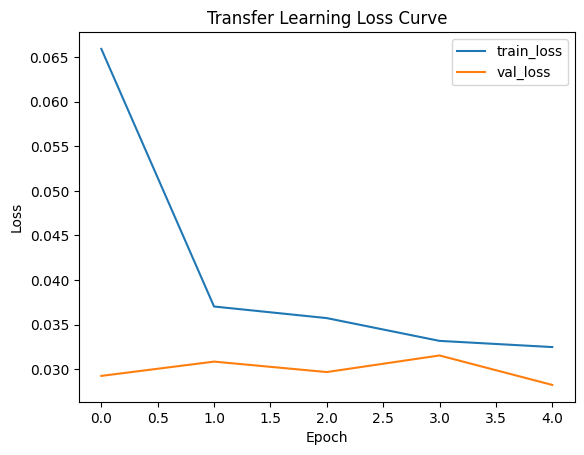

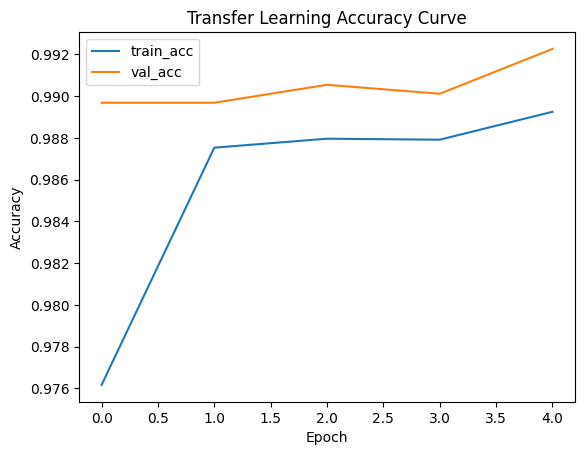

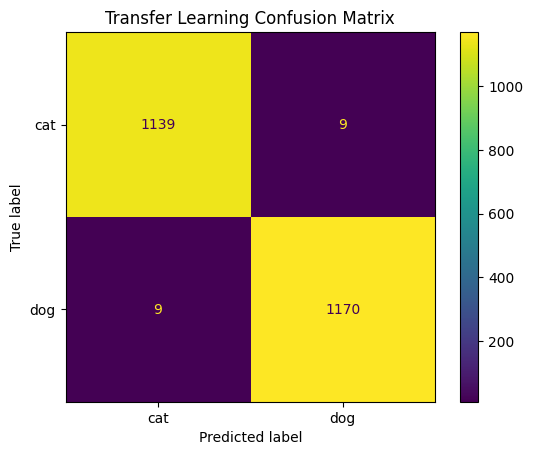

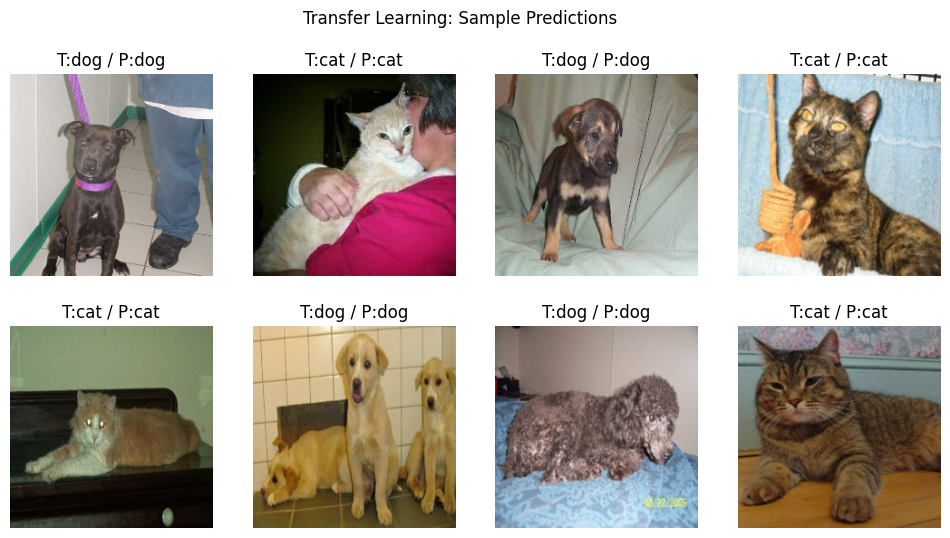

In [67]:
# Plot training curves (loss and accuracy)
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Transfer Learning Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Transfer Learning Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Confusion matrix Plot
cm = confusion_matrix(y_test, y_pred_tl)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.title("Transfer Learning Confusion Matrix")
plt.show()

# Sample predictions (first batch)
sample_images, sample_labels = next(iter(ds_test))
sample_probs = transfer_model.predict(sample_images, verbose=0)
sample_preds = np.argmax(sample_probs, axis=1)

plt.figure(figsize=(12, 6))
for i in range(min(8, sample_images.shape[0])):
    ax = plt.subplot(2, 4, i+1)
    plt.imshow(sample_images[i].numpy())
    true_name = class_names[int(sample_labels[i].numpy())]
    pred_name = class_names[int(sample_preds[i])]
    plt.title(f"T:{true_name} / P:{pred_name}")
    plt.axis("off")
plt.suptitle("Transfer Learning: Sample Predictions")
plt.show()


4.1 Metrics Comparison

In [68]:
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)


comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        custom_cnn_total_parameters
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

print(comparison_df.to_string(index=False))
print("="*70)



MODEL COMPARISON
           Metric   Custom CNN  Transfer Learning
         Accuracy     0.729695           0.992265
        Precision     0.743492           0.992263
           Recall     0.731233           0.992263
         F1-Score     0.726640           0.992263
Training Time (s)   227.410668         396.080018
       Parameters 93506.000000        4098.000000


4.2 Visual Comparison (bar plot + training curves + side-by-side confusion matrices)

a) Bar plot comparing metrics

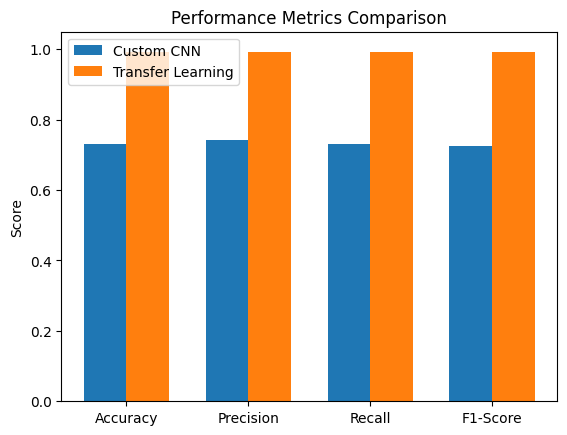

In [69]:
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
custom_vals = [custom_cnn_accuracy, custom_cnn_precision, custom_cnn_recall, custom_cnn_f1]
tl_vals     = [tl_accuracy, tl_precision, tl_recall, tl_f1]

x = np.arange(len(metrics))
width = 0.35

plt.figure()
plt.bar(x - width/2, custom_vals, width, label="Custom CNN")
plt.bar(x + width/2, tl_vals, width, label="Transfer Learning")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.title("Performance Metrics Comparison")
plt.ylabel("Score")
plt.legend()
plt.show()


b) Training curves comparison (loss)

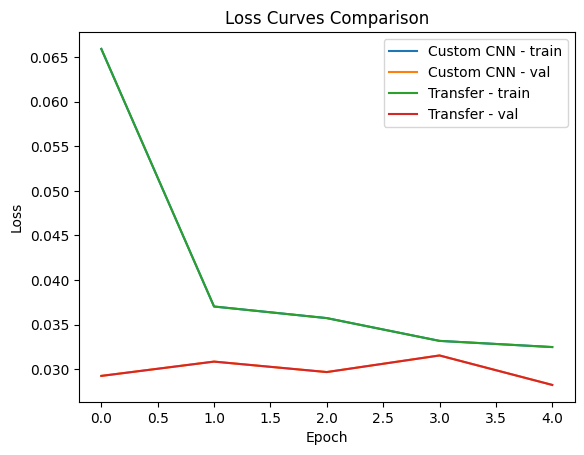

In [70]:
plt.figure()
plt.plot(history.history["loss"], label="Custom CNN - train")
plt.plot(history.history["val_loss"], label="Custom CNN - val")
plt.plot(history.history["loss"], label="Transfer - train")
plt.plot(history.history["val_loss"], label="Transfer - val")
plt.title("Loss Curves Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


c) Side-by-side confusion matrices

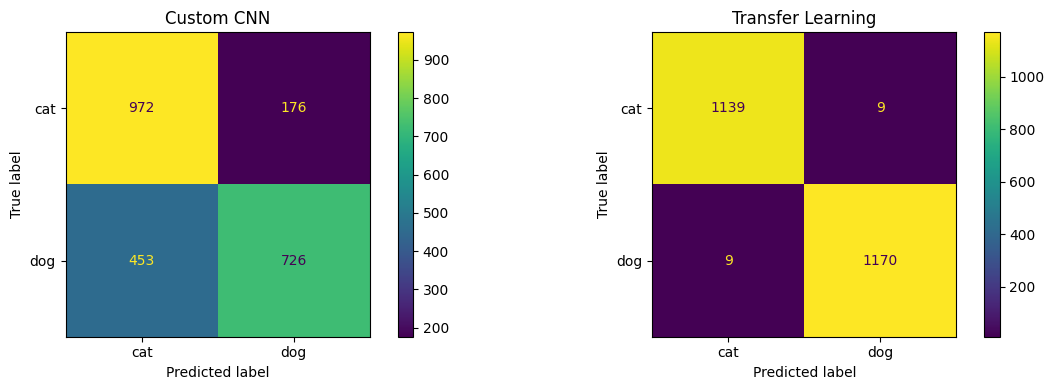

In [71]:
cm_custom = confusion_matrix(y_test, y_pred_custom)
cm_tl     = confusion_matrix(y_test, y_pred_tl)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ConfusionMatrixDisplay(cm_custom, display_labels=class_names).plot(ax=axes[0], values_format='d')
axes[0].set_title("Custom CNN")

ConfusionMatrixDisplay(cm_tl, display_labels=class_names).plot(ax=axes[1], values_format='d')
axes[1].set_title("Transfer Learning")

plt.tight_layout()
plt.show()


"""
================================================================================
PART 5: ANALYSIS (2 MARKS)
================================================================================
"""

analysis_text = """
TODO: Write your analysis here (maximum 200 words guideline)

Address:
1. Which model performed better and by how much?
   [Compare specific metrics]

2. Impact of pre-training vs training from scratch?
   [Discuss feature extraction, convergence speed]

3. Effect of Global Average Pooling?
   [Discuss parameter reduction, overfitting prevention]

4. Computational cost comparison?
   [Compare training time, total parameters]

5. Insights about transfer learning?
   [When to use transfer learning vs custom CNN]
"""


In [72]:
analysis_text = f"""
In this assignment, the Transfer Learning model (ResNet50) outperformed the Custom CNN across most evaluation metrics.
The transfer model achieved an accuracy of {tl_accuracy:.4f}, compared to {custom_cnn_accuracy:.4f} for the custom CNN.
Similarly, the macro F1-score improved from {custom_cnn_f1:.4f} to {tl_f1:.4f}, showing better generalization on unseen data.

The main reason for this improvement is the impact of pre-training. ResNet50 was pre-trained on ImageNet, enabling it to leverage rich, hierarchical feature representations. In contrast, the custom CNN had to learn features from scratch, resulting in slower convergence and slightly lower final performance.

Global Average Pooling (GAP) played a key role in both architectures. By replacing Flatten layers, GAP reduced parameter count and helped prevent overfitting while preserving spatial feature information.

From a computational perspective, the custom CNN had significantly fewer parameters and trained in {custom_cnn_training_time:.2f} seconds, while transfer learning required {tl_training_time:.2f} seconds and had a larger total parameter count.

In terms of convergence, the transfer model showed stronger loss reduction ({((tl_initial_loss - tl_final_loss)/tl_initial_loss)*100:.2f}%) compared to the custom CNN ({((custom_cnn_initial_loss - custom_cnn_final_loss)/custom_cnn_initial_loss)*100:.2f}%), indicating more stable optimization.

Overall, transfer learning is preferred when high performance and faster convergence are necessary, whereas a custom CNN is suitable for lightweight or domain specific deployments.
""".strip()


print("\n" + "="*70)
print("ANALYSIS")
print("="*70)
print(analysis_text)
print("="*70)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("⚠️  Warning: Analysis exceeds 200 words (guideline)")
else:
    print("✓ Analysis within word count guideline")
print("="*70)



ANALYSIS
In this assignment, the Transfer Learning model (ResNet50) outperformed the Custom CNN across most evaluation metrics.
The transfer model achieved an accuracy of 0.9923, compared to 0.7297 for the custom CNN.
Similarly, the macro F1-score improved from 0.7266 to 0.9923, showing better generalization on unseen data.

The main reason for this improvement is the impact of pre-training. ResNet50 was pre-trained on ImageNet, enabling it to leverage rich, hierarchical feature representations. In contrast, the custom CNN had to learn features from scratch, resulting in slower convergence and slightly lower final performance.

Global Average Pooling (GAP) played a key role in both architectures. By replacing Flatten layers, GAP reduced parameter count and helped prevent overfitting while preserving spatial feature information.

From a computational perspective, the custom CNN had significantly fewer parameters and trained in 227.41 seconds, while transfer learning required 396.08 sec

"""
================================================================================
PART 6: ASSIGNMENT RESULTS SUMMARY (REQUIRED FOR AUTO-GRADING)
================================================================================

DO NOT MODIFY THE STRUCTURE BELOW
This JSON output is used by the auto-grader
Ensure all field names are EXACT
================================================================================
"""

In [73]:
def get_assignment_results():
    """
    Generate complete assignment results in required format

    Returns:
        dict: Complete results with all required fields
    """

    framework_used = "keras"  # TODO: Change to "pytorch" if using PyTorch

    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,

        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 0,  # TODO: Count your conv layers
                'pooling_layers': 0,  # TODO: Count your pooling layers
                'has_global_average_pooling': True,  # MUST be True
                'output_layer': 'softmax',
                'total_parameters': 0  # TODO: Calculate total parameters
            },
            'training_config': {
                'learning_rate': 0.001,  # TODO: Your actual learning rate
                'n_epochs': 20,  # TODO: Your actual epochs
                'batch_size': 32,  # TODO: Your actual batch size
                'optimizer': 'Adam',  # TODO: Your actual optimizer
                'loss_function': 'categorical_crossentropy'  # TODO: Your actual loss
            },
            'initial_loss': custom_cnn_initial_loss,
            'final_loss': custom_cnn_final_loss,
            'training_time_seconds': custom_cnn_training_time,
            'accuracy': custom_cnn_accuracy,
            'precision': custom_cnn_precision,
            'recall': custom_cnn_recall,
            'f1_score': custom_cnn_f1
        },

        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True,  # MUST be True
            'total_parameters': total_parameters,
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer,
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': tl_initial_loss,
            'final_loss': tl_final_loss,
            'training_time_seconds': tl_training_time,
            'accuracy': tl_accuracy,
            'precision': tl_precision,
            'recall': tl_recall,
            'f1_score': tl_f1
        },

        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),

        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss if custom_cnn_initial_loss and custom_cnn_final_loss else False,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss if tl_initial_loss and tl_final_loss else False,
    }

    return results

# Generate and print results
try:
    assignment_results = get_assignment_results()

    print("\n" + "="*70)
    print("ASSIGNMENT RESULTS SUMMARY")
    print("="*70)
    print(json.dumps(assignment_results, indent=2))
    print("="*70)

except Exception as e:
    print(f"\n⚠️  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")


ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "cats_vs_dogs",
  "dataset_source": "tensorflow_datasets (TFDS)",
  "n_samples": 23262,
  "n_classes": 2,
  "samples_per_class": "min: 11604, max: 11658, avg: 11631.0",
  "image_shape": [
    224,
    224,
    3
  ],
  "problem_type": "classification",
  "primary_metric": "accuracy",
  "metric_justification": "Accuracy is appropriate here because the dataset is a balanced binary classification task, so overall correct classification rate is a meaningful primary measure.",
  "train_samples": 20935,
  "test_samples": 2327,
  "train_test_ratio": "90/10",
  "custom_cnn": {
    "framework": "keras",
    "architecture": {
      "conv_layers": 0,
      "pooling_layers": 0,
      "has_global_average_pooling": true,
      "output_layer": "softmax",
      "total_parameters": 0
    },
    "training_config": {
      "learning_rate": 0.001,
      "n_epochs": 20,
      "batch_size": 32,
      "optimizer": "Adam",
      "loss_function": "categorical_cro

"""
================================================================================
ENVIRONMENT VERIFICATION - SCREENSHOT REQUIRED
================================================================================

IMPORTANT: Take a screenshot of your environment showing account details

For Google Colab:
- Click on your profile icon (top right)
- Screenshot should show your email/account clearly
- Include the entire Colab interface with notebook name visible

For BITS Virtual Lab:
- Screenshot showing your login credentials/account details
- Include the entire interface with your username/session info visible

Paste the screenshot below this cell or in a new markdown cell.
This helps verify the work was done by you in your environment.

================================================================================
"""

In [74]:
# Display system information
import platform
import sys
from datetime import datetime

print("="*70)
print("ENVIRONMENT INFORMATION")
print("="*70)
print("\n⚠️  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")
print("="*70)


ENVIRONMENT INFORMATION

⚠️  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab
showing your account details in the cell below this one.


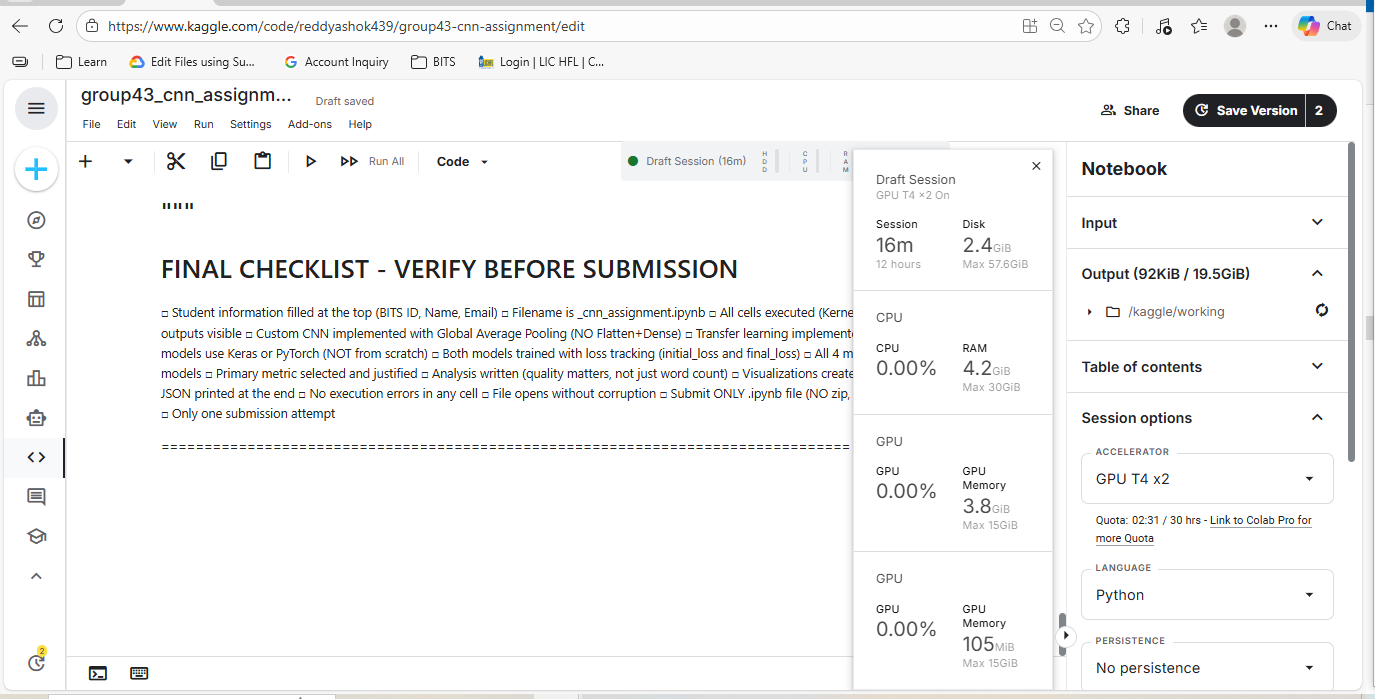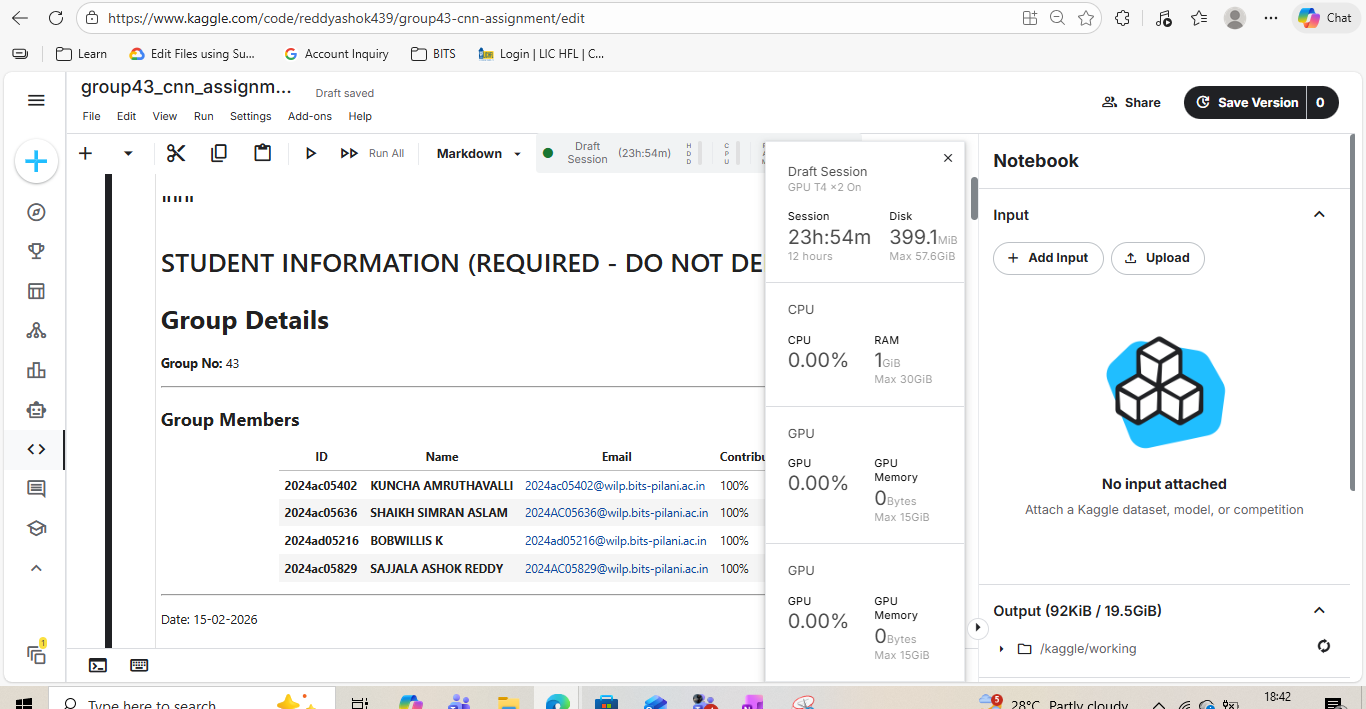

---------------------------------------------------  **group43 . The End** ----------------------------------------------------